# Main Jupyter notebook for Urdf2Moon

Jupyter used for debugging. We try to add a term to the cost function which is dependent by the final state and the final control value

In [1]:
import casadi as cs
from urdf2casadi import urdfparser as u2c
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

%matplotlib inline

In [2]:
class Urdf2Moon:
    def __init__(self, urdf_path, root, tip):
        self.robot_parser = self.load_urdf(urdf_path)

        # Store inputs
        self.root = root
        self.tip = tip

        # Get basic info
        self.num_joints = self.get_joints_n(self.root, self.tip)
        self.q, self.q_dot, self.u_hat = self.define_symbolic_vars(self.num_joints)
        self.M, self.Cq, self.G = self.get_motion_equation_matrix(self.root, self.tip, self.q, self.q_dot)
        self.M_inv = cs.pinv(self.M)
        self.u = self.u_hat + self.G
        self.upper_x, self.lower_x = self.get_limits(self.root, self.tip)



    def solve(self, cost_func, time_horizon=5, control_steps=100, initial_cond=[1,1,0,0], upper_u = None, lower_u=None, rk_interval=4):
        #Store Values
        self.cost_func = cost_func
        self.T = time_horizon
        self.N = control_steps
        self.initial_cond = initial_cond
        self.rk_intervals = rk_interval
        # Fix upper values if not given
        if upper_u == None:
            self.upper_u = [float('inf')] * self.num_joints
            self.lower_u = [-float('inf')] * self.num_joints
        else:
            self.upper_u = upper_u
            self.lower_u = lower_u

        # Working it up
        self.f = self.get_diff_eq(self.cost_func)
        self.F = self.rk4(self.f, self.T, self.N, self.rk_intervals)
        self.u_hat_opt = self.nlp_solver(self.initial_cond, self.upper_x, self.lower_x, self.upper_u, self.lower_u)
        self.x_opt = self.get_x_opt(self.F, self.u_hat_opt, self.initial_cond)


    def define_symbolic_vars(self, num_joints):
        q = cs.SX.sym("q", num_joints)
        q_dot = cs.SX.sym("q_dot", num_joints)
        u_hat = cs.SX.sym("u_hat", num_joints)
        return q, q_dot, u_hat

    def load_urdf(self, urdf_path):
        robot_parser = u2c.URDFparser()
        robot_parser.from_file(urdf_path)
        return robot_parser

    def get_joints_n(self, root, tip):
        return self.robot_parser.get_n_joints(root, tip) #return the number of actuated joints

    def get_limits(self, root, tip):
        _, _, upper, lower = self.robot_parser.get_joint_info(root, tip)
        return upper, lower

    def get_motion_equation_matrix(self, root, tip, q, q_dot):
        # load inertia terms (function)
        M_sym = self.robot_parser.get_inertia_matrix_crba(root, tip)
        # load gravity terms (function)
        gravity_u2c = [0, 0, -9.81]
        G_sym = self.robot_parser.get_gravity_rnea(root, tip, gravity_u2c)
        # load Coriolis terms (function)
        C_sym = self.robot_parser.get_coriolis_rnea(root, tip)
        return M_sym(q), C_sym(q, q_dot), G_sym(q)

    def get_diff_eq(self, cost_func):
        lhs1 = self.q_dot
        lhs2 = -cs.mtimes(self.M_inv, self.Cq) + cs.mtimes(self.M_inv, self.u_hat)
        J_dot = cost_func(self.q, self.q_dot, self.u)
        self.x = cs.vertcat(self.q, self.q_dot)
        self.x_dot = cs.vertcat(lhs1, lhs2)
        f = cs.Function('f', [self.x, self.u_hat],    # inputs
                             [self.x_dot, J_dot])  # outputs
        return f

    def rk4(self, f, T, N, m):
        dt = T/N/m

        # variable definition for RK method
        X0 = cs.MX.sym('X0', self.num_joints * 2)
        U = cs.MX.sym('U', self.num_joints)

        # Initial value
        X = X0
        Q = 0

        # Integration
        for j in range(m):
            k1, k1_q = f(X,  U)
            k2, k2_q = f(X + dt/2 * k1, U)
            k3, k3_q = f(X + dt/2 * k2, U)
            k4, k4_q = f(X + dt * k3, U)
            # update the state
            X = X + dt/6*(k1 +2*k2 +2*k3 +k4)
            # update the cost function
            Q = Q + dt/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)

        F = cs.Function('F', [X0, U], [X, Q],['x0','p'],['xf','qf'])
        return F

    def nlp_solver(self, initial_cond, upper_x, lower_x, upper_u, lower_u):
        # Start with an empty NLP
        u       = []    #input vector
        u_g     = []    #initial guess
        lbu     = []    #lower bounds of inputs
        ubu     = []    #upper bounds of inputs
        J       = 0     #initial value of cost func
        g       = []    #joint state for all timesteps
        lbx     = []    #lower bounds of states
        ubx     = []    #upper bound of states

        #populating most of them
        for k in range(self.N):
            u_g  += [0] * self.num_joints   # Initial guess for every timestamp
            lbu += lower_u            # lower limit for control
            ubu += upper_u               # upper limit for control
            lbx += lower_x
            ubx += upper_x

        Xk = cs.MX(initial_cond) # MUST be coherent with the condition specified abow

        # Integration!
        for k in range(self.N):
            Uk = cs.MX.sym('U_' + str(k), self.num_joints) # generate the k-th control command, 2x1 dimension
            u += [Uk]        # list of commands [U_0, U_1, ..., U_(N-1)]

            Fk = self.F(x0=Xk, p=Uk)     #That's the actual integration!
            Xk = Fk['xf']
            J  = J+Fk['qf']

            # Add inequality constraint
            g.append(Xk[0:self.num_joints])    # g += [x_1, x_2, x_1d, x_2d]

        # Define the problem to be solved
        problem = {'f': J, 'x': cs.vertcat(*u), 'g': cs.vertcat(*g)}
        # NLP solver options
        opts = {}
        opts["ipopt"] = dict(max_iter=100)
        # Define the solver and add boundary conditions
        solver = cs.nlpsol('solver', 'ipopt', problem, opts)
        solver = solver(x0=u_g, lbx=lbu, ubx=ubu, lbg=lbx, ubg=ubx)

        # Solve the NLP
        u_hat_opt = solver['x']
        return u_hat_opt

    def get_x_opt(self, F, u, initial_cond):
        x_opt = [np.array(initial_cond)]    # must be the same as before!
        for k in range(self.N):
            u_t = cs.vertcat(u[k*self.num_joints:(k+1)*self.num_joints])
            Fk = F(x0=x_opt[-1], p=u_t)
            x_opt += [Fk['xf'].full()]

        # now we want x_res = [q1,q2,q1_dot, q2_dot]
        x_res = [np.array([r[k] for r in x_opt], dtype='f') for k in range(2*self.num_joints)]
        return x_res

    def print_results(self):
        tgrid = [self.T/self.N*k for k in range(self.N+1)]

        fig, axes = plt.subplots(nrows=ceil(self.num_joints/2), ncols=2, figsize=(15, 4*ceil(self.num_joints/2)))

        for idx, ax in enumerate(fig.axes):
            self.get_ax(ax, idx, tgrid)

        return fig

    def get_ax(self, ax, idx, tgrid):
        ax.plot(tgrid, self.x_opt[idx], '-')
        ax.plot(tgrid, self.x_opt[self.num_joints+idx], '--')
        ax.plot(tgrid[1:], self.u_hat_opt[idx::self.num_joints], '-.')
        ax.legend(['q'+str(idx),'q' + str(idx) +'_dot', 'u' + str(idx)])
        return ax


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    20200
Number of nonzeros in Lagrangian Hessian.............:    20100

Total number of variables............................:      200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

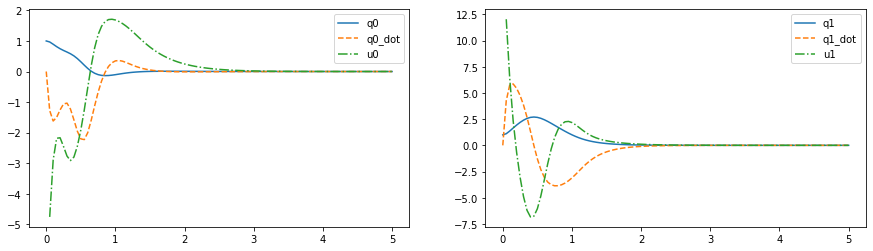

In [3]:
if __name__ == '__main__':
    urdf_path = "../urdf/rrbot.urdf"     # path to urdf
    root_link = "link1"
    end_link = "link3"

    def my_cost_func(q, qd, u):
        return 10*cs.mtimes(q.T,q) + cs.mtimes(qd.T,qd) + cs.mtimes(u.T,u)

    time_horizon = 5
    steps = 100
    in_cond = [1,1,0,0]

    urdf_2_opt = Urdf2Moon(urdf_path, root_link, end_link)
    urdf_2_opt.solve(my_cost_func, time_horizon, steps, in_cond)
    urdf_2_opt.print_results()